### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ($\epsilon$と$\sigma$)を学習する

### 必要なパッケージを読み込む

In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using Distributions
using MDToolbox

### ポテンシャルエネルギー関数の定義

In [2]:
#2原子の距離を用いポテンシャルを計算
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

#nステップ目のポテンシャルを計算
function sum_compute_energy(coords, epsilon, sigma)
    U = 0
    for i in 1:size(coords, 1)-1
        for j in (i+1):size(coords, 1)
            U += compute_energy(coords[i], coords[j], epsilon, sigma)
        end
    end
    return U
end

sum_compute_energy (generic function with 1 method)

In [3]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

In [4]:
#n原子の軌跡からFを計算
#coords_trj = data_k[i]
function compute_free_energy(coords_trj, beta, epsilon, sigma)
    N = size(coords_trj, 1) #ステップ数
    U_array = [sum_compute_energy(coords_trj[i], epsilon, sigma) for i in 1:size(coords_trj, 1)] #Nステップのポテンシャルの値を入れた配列
    F = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta * U_array)) #U_arrayを積分してFを計算
    return F
end

#EXP
function compute_deltaF(coords_trj, beta, epsilon, sigma, epsilon_target, sigma_target)
    N = size(coords_trj, 1) #原子数
    #U_array = [sum_compute_energy(coords_trj[i], epsilon, sigma) for i in 1:N]
    U_array = sum_compute_energy.(coords_trj, epsilon, sigma) #シミュレーションのパラメータを用いポテンシャルを計算
    #U_target_array = [sum_compute_energy(coords_trj[i], epsilon_target, sigma_target) for i in 1:N]
    U_target_array = sum_compute_energy.(coords_trj, epsilon_target, sigma_target) #実験のパラメータを用いポテンシャルを計算
    deltaU = U_target_array - U_array
    deltaF = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* deltaU))
    return deltaF
end

compute_deltaF (generic function with 1 method)

### ポテンシャルエネルギー関数を持つFluxのカスタムレイヤの定義

In [5]:
struct Energy
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor Energy (P,)

(m::Energy)(coords_trj, beta, epsilon, sigma) = compute_deltaF(coords_trj, beta, epsilon, sigma, m.P[1], m.P[2])

### MCMCの定義

In [6]:
#次のステップ候補点
function next_coords(coords, delta_x=1e-2)
    next_coords = map(x -> x .+ (rand(3) .- 0.5) .* delta_x, coords)
    return next_coords
end

next_coords (generic function with 2 methods)

In [7]:
#MCMC,メトロポリス法
function mcmc(coords, epsilon, sigma, nstep=100, beta=1.0)
    coords_trj = []
    alpha_trj = []
    push!(coords_trj, copy.(coords))
    
    for i in 1:nstep
        next_coords_tmp = next_coords(coords) #候補点
        delta_U = sum_compute_energy(next_coords_tmp, epsilon, sigma) - sum_compute_energy(coords, epsilon, sigma)
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha > rand()
            coords = next_coords_tmp
        end     
        push!(coords_trj, copy.(coords))
        push!(alpha_trj, alpha)
    end
    return coords_trj, alpha_trj
end

mcmc (generic function with 3 methods)

### 訓練データの作成

In [8]:
#パラメータ
param_set = [(1.0, 2.0), (1.2, 2.5)] #params_set[i] = (epsilon[i], sigma[i])
data_k = []
K = size(param_set, 1) - 1 #最後のパラメータの値を推定する
natom = 3
kBT = 2.0
beta = 1.0/(kBT)
nstep = 10000

for i in 1:size(param_set, 1)
    use_param = i #使うパラメータ
    epsilon = param_set[use_param][1]
    sigma = param_set[use_param][2]

    coords = [[[sigma * x + rand(), rand(), rand()] for x in 1:natom]...]  #初期座標

    #nstepのMCMC
    coords_trj, alpha = mcmc(coords, epsilon, sigma, nstep, beta)
    push!(data_k, coords_trj)
end

In [9]:
#data_k[1:end-1]はシミュレーションの軌道
#data_k[end]は実験の軌道で分かっていないものとする
size(data_k)

(2,)

In [10]:
#シミュレーションのパラメータ
epsilon = param_set[1][1]
sigma = param_set[1][2]

#実験のパラメータ,分かっていないものとして考える
epsilon_target = param_set[2][1]
sigma_target = param_set[2][2]

2.5

In [11]:
#FとF_targetを計算
F = compute_free_energy(data_k[1], beta, epsilon, sigma)
F_target = compute_free_energy(data_k[end], beta, epsilon_target, sigma_target)

#パラメータ推定に用いる原子の軌跡と自由エネルギーの差
X_train = data_k[1]    #シミュレーションの座標
y_train = F_target - F #自由エネルギー差

#EXPを用いて自由エネルギー差を推定
deltaF = compute_deltaF(data_k[1], beta, epsilon, sigma, epsilon_target, sigma_target)

0.8798798506541559

In [12]:
println("F = $(F)")
println("F_target = $(F_target)")
println("(F_target - F) = $(F_target - F)")
println("deltaF = $(deltaF)")

F = -0.8858844865583038
F_target = -1.566830788057434
(F_target - F) = -0.6809463014991302
deltaF = 0.8798798506541559


### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [13]:
# Lossの定義
m = Energy([1.0, 2.7])
loss(X, y) = Flux.Losses.mse(m(X, beta, epsilon, sigma), y)
loss(X_train, y_train)

21.87069420752133

In [14]:
# DataやOptimizerの定義
#train_loader = Flux.Data.DataLoader((data=X_train, label=y_train), batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-2) 

Adam(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [15]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [16]:
# 訓練
loss_train = []

for epoch in 1:51
    gs = gradient(() -> loss(X_train, y_train), ps)
    Flux.Optimise.update!(opt, ps, gs)
    
    push!(loss_train, loss(X_train, y_train))
    if epoch%10 == 1
        print_callback(epoch, loss(X_train, y_train), ps)
    end
end

Epoch: 1, loss: 19.76460131268231
param: [0.9900000000106226, 2.69000000000047]
Epoch: 11, loss: 8.118378040771328
param: [0.9165538914837643, 2.596074008856553]
Epoch: 21, loss: 4.266327144931675
param: [0.93875570873402, 2.5226405697322445]
Epoch: 31, loss: 2.5327788302668375
param: [1.018638393286936, 2.4708062823418353]
Epoch: 41, loss: 1.576070668150007
param: [1.114020565571486, 2.435392226373309]
Epoch: 51, loss: 0.9933502584279317
param: [1.2080478779242816, 2.4111487270718515]


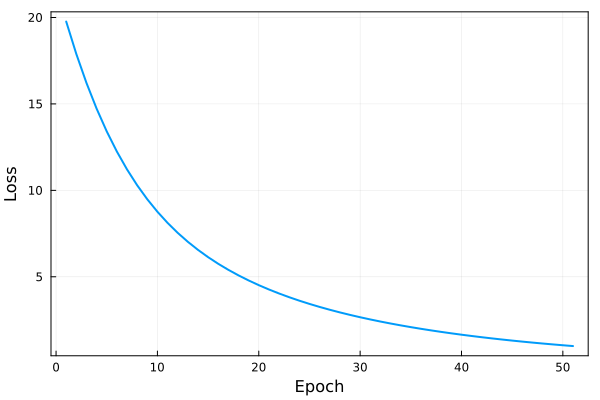

In [17]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2)
ylabel!("Loss")
xlabel!("Epoch")

In [18]:
println("Ground-truth epsilon: ", epsilon_target)
println("Estimate epsilon:     ", m.P[1])

println("Ground-truth sigma: ", sigma_target)
println("Estimate sigma:     ", m.P[2])

Ground-truth epsilon: 1.2
Estimate epsilon:     1.2080478779242816
Ground-truth sigma: 2.5
Estimate sigma:     2.4111487270718515
